In [1]:
# 🚀 RTV fragments: upload → features (word+char ngrams + numeric + quantifiers) → class-balanced training
# → threshold tuning → visual CMs → optional embeddings → save+zip


# ====== SETTINGS ======
USE_EMBEDDINGS   = True      # set False to skip MiniLM embeddings variant
USE_OVERSAMPLING = False     # set True to oversample minority (training folds only)
SEP_TOKEN        = "[SEP]"
RANDOM_STATE     = 42
CLASS_NAMES      = ["unsat", "sat"]  # 0 -> unsat, 1 -> sat

# TF-IDF settings (RTV-friendly)
WORD_NGRAM_RANGE   = (1, 3)
CHAR_NGRAM_RANGE   = (3, 5)          # char_wb helps capture " no ", " not ", " any "
MAX_WORD_FEATURES  = 20000
MAX_CHAR_FEATURES  = 30000

# Embeddings
EMB_MODEL_NAME     = "sentence-transformers/all-MiniLM-L6-v2"

# ====== IMPORTS ======
import os, io, json, ast, sys, subprocess, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support,
    balanced_accuracy_score, f1_score, make_scorer
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import joblib

# Optional: oversampling
if USE_OVERSAMPLING:
    try:
        from imblearn.over_sampling import RandomOverSampler
    except Exception:
        !pip -q install imbalanced-learn
        from imblearn.over_sampling import RandomOverSampler

SAVE_DIR = Path("models_out"); SAVE_DIR.mkdir(parents=True, exist_ok=True)
fname = "relativetransitiveverb.csv"



In [2]:
# ====== HELPERS ======
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in {"sat","satisfiable","1","true"}:  return 1
        if s in {"unsat","unsatisfiable","0","false"}:  return 0
    if isinstance(v, (int, np.integer)):
        if v in (0,1): return int(v)
    raise ValueError(f"Unrecognized label: {v!r}")

def parse_sent(cell, sep=SEP_TOKEN):
    if isinstance(cell, list): return f" {sep} ".join(cell)
    if isinstance(cell, str):
        s = cell.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list) and all(isinstance(x, str) for x in parsed):
                    return f" {sep} ".join(parsed)
            except Exception:
                pass
        return s
    return str(cell)

def safe_literal_eval_maybe_list(x):
    if isinstance(x, (list, tuple)): return x
    if isinstance(x, str):
        s = x.strip()
        if s and (s[0] in "[(" and s[-1] in "])"):
            try:
                return ast.literal_eval(s)
            except Exception:
                return x
    return x

def extract_quantifier_features(qcell):
    """
    Counts singles (all, exists) and ordered pairs (all_all, all_exists, exists_all, exists_exists).
    Works with nested lists like ['exists','all'] or [['exists','exists'], 'all', ...]
    """
    singles = {"all":0, "exists":0}
    pairs   = {"all_all":0, "all_exists":0, "exists_all":0, "exists_exists":0}
    def rec(node):
        if isinstance(node, str):
            s = node.strip().lower()
            if s in singles: singles[s] += 1
        elif isinstance(node, (list, tuple)):
            if len(node) == 2 and all(isinstance(x, str) for x in node):
                a = node[0].strip().lower(); b = node[1].strip().lower()
                if a in singles and b in singles:
                    pairs[f"{a}_{b}"] += 1
            for child in node:
                rec(child)
    rec(qcell)
    out = {
        "q_all": singles["all"], "q_exists": singles["exists"],
        "q_all_all": pairs["all_all"], "q_all_exists": pairs["all_exists"],
        "q_exists_all": pairs["exists_all"], "q_exists_exists": pairs["exists_exists"],
    }
    out["q_single_total"] = out["q_all"] + out["q_exists"]
    out["q_pair_total"]   = out["q_all_all"] + out["q_all_exists"] + out["q_exists_all"] + out["q_exists_exists"]
    return out

def metrics(y_true, y_pred, avg="macro"):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=avg, zero_division=0)
    return {"accuracy": acc, f"precision_{avg}": p, f"recall_{avg}": r, f"f1_{avg}": f1}

def plot_cm(cm, class_names, title, normalize=False, save_path=None):
    cm_plot = cm.astype(float)
    if normalize:
        row_sums = cm_plot.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0.0] = 1.0
        cm_plot = cm_plot / row_sums
    plt.figure(figsize=(4.5, 4))
    im = plt.imshow(cm_plot, interpolation='nearest', cmap='Blues', aspect='equal')
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    thresh = cm_plot.max() / 2.0 if cm_plot.max() > 0 else 0.5
    for i in range(cm_plot.shape[0]):
        for j in range(cm_plot.shape[1]):
            val = f"{cm_plot[i, j]:.2f}" if normalize else f"{int(cm_plot[i, j])}"
            plt.text(j, i, val, ha="center", va="center",
                     color="white" if cm_plot[i, j] > thresh else "black", fontsize=11)
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

def tune_threshold(scores, y_true, use_proba=True):
    """Sweep thresholds to maximize macro-F1."""
    import numpy as np
    if use_proba:  thr_grid = np.linspace(0.1, 0.9, 33)
    else:          thr_grid = np.percentile(scores, np.linspace(5, 95, 33))
    best_t, best_f1 = None, -1
    for t in thr_grid:
        y_pred = (scores >= t).astype(int)
        f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
        if f1m > best_f1: best_f1, best_t = f1m, t
    return best_t, best_f1

SCORING = {"f1_macro": "f1_macro", "balanced_accuracy": make_scorer(balanced_accuracy_score)}
REFIT   = "f1_macro"


In [3]:
# ====== LOAD + FEATURES ======
df = pd.read_csv(fname)
label_col = "label" if "label" in df.columns else "sat" if "sat" in df.columns else None
if label_col is None: raise ValueError("No label column found. Expected 'label' or 'sat'.")
if "sentences" not in df.columns: raise ValueError("Expected a 'sentences' column.")

df["y"] = df[label_col].apply(normalize_label).astype(int)
df["text"] = df["sentences"].apply(parse_sent)

# numeric base features
base_numeric_cols = [c for c in ["unary","binary","num_clauses","prob"] if c in df.columns]
for c in base_numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# quantifier features (nested-list aware)
quant_cols = []
if "quantifiers" in df.columns:
    qfeats = []
    for raw in df["quantifiers"]:
        parsed = safe_literal_eval_maybe_list(raw)
        qfeats.append(extract_quantifier_features(parsed))
    qfeats = pd.DataFrame(qfeats)
    df = pd.concat([df, qfeats], axis=1)
    quant_cols = list(qfeats.columns)

numeric_cols = base_numeric_cols + quant_cols
X_full = df[["text"] + numeric_cols].copy()
y = df["y"].to_numpy()
Xtr_df, Xval_df, ytr, yval = train_test_split(X_full, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Optional oversampling (training only)
if USE_OVERSAMPLING:
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    Xtr_df, ytr = ros.fit_resample(Xtr_df, ytr)
    print("Oversampled training shape:", Xtr_df.shape, "class balance:", np.bincount(ytr))


In [4]:
# ====== TF-IDF (word+char) + NUMERIC via ColumnTransformer ======
word_vec = TfidfVectorizer(ngram_range=WORD_NGRAM_RANGE, max_features=MAX_WORD_FEATURES)
char_vec = TfidfVectorizer(analyzer="char_wb", ngram_range=CHAR_NGRAM_RANGE, max_features=MAX_CHAR_FEATURES)

# Apply both vectorizers to the same 'text' column, plus numeric features
preproc = ColumnTransformer(
    transformers=[
        ("word", word_vec, "text"),
        ("char", char_vec, "text"),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value=0.0)),
            ("scale", StandardScaler(with_mean=False)),  # stays sparse-friendly
        ]), numeric_cols) if numeric_cols else ("drop", "drop", numeric_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3,
)

spaces = {}
spaces["logreg_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LogisticRegression(
                  solver="liblinear", max_iter=1000, random_state=RANDOM_STATE,
                  class_weight="balanced"
              ))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)
spaces["svm_linear_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", LinearSVC(class_weight="balanced"))]),
    {"clf__C": [0.01, 0.1, 1.0, 10.0]},
    -1
)
spaces["decision_tree_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))]),
    {"clf__criterion": ["gini", "entropy"], "clf__max_depth": [10, 20, None]},
    -1
)
spaces["random_forest_tfidf"] = (
    Pipeline([("prep", preproc),
              ("clf", RandomForestClassifier(
                  random_state=RANDOM_STATE, class_weight="balanced_subsample"
              ))]),
    {"clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100, 200], "clf__max_features": ["sqrt"]},
    -1
)

summary = {"file": fname, "numeric_cols": numeric_cols, "results": {}}



=== logreg_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.01} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4265    0.6818    0.5247       506
           1     0.8648    0.6894    0.7672      1494

    accuracy                         0.6875      2000
   macro avg     0.6456    0.6856    0.6460      2000
weighted avg     0.7539    0.6875    0.7059      2000



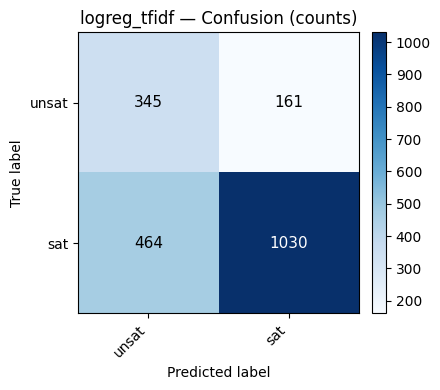

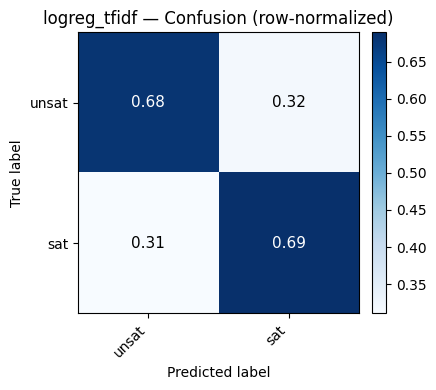


Validation report (threshold-tuned via proba, thr=0.3750, macro-F1=0.6607):
              precision    recall  f1-score   support

           0     0.5195    0.4486    0.4814       506
           1     0.8215    0.8594    0.8400      1494

    accuracy                         0.7555      2000
   macro avg     0.6705    0.6540    0.6607      2000
weighted avg     0.7451    0.7555    0.7493      2000



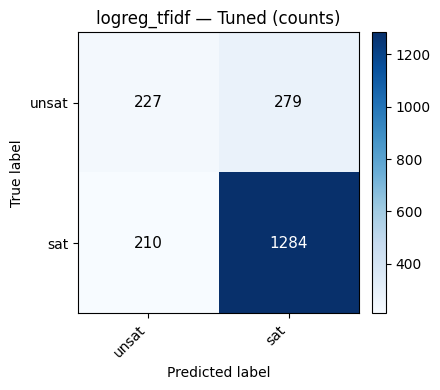

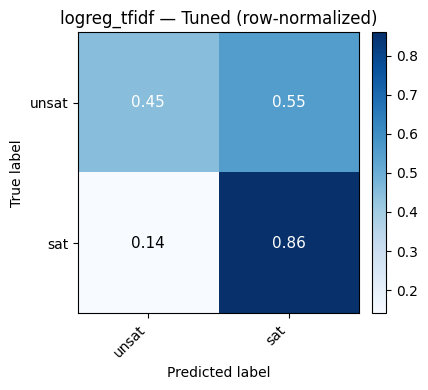


=== svm_linear_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__C': 0.01} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4203    0.6561    0.5123       506
           1     0.8562    0.6934    0.7663      1494

    accuracy                         0.6840      2000
   macro avg     0.6382    0.6748    0.6393      2000
weighted avg     0.7459    0.6840    0.7020      2000



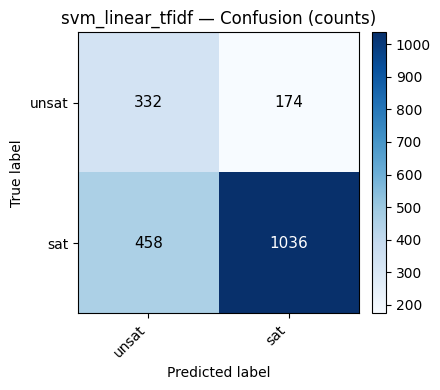

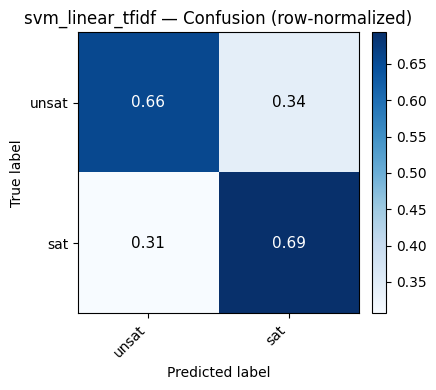


Validation report (threshold-tuned via decision, thr=-0.1923, macro-F1=0.6587):
              precision    recall  f1-score   support

           0     0.4939    0.4822    0.4880       506
           1     0.8260    0.8327    0.8293      1494

    accuracy                         0.7440      2000
   macro avg     0.6600    0.6574    0.6587      2000
weighted avg     0.7420    0.7440    0.7430      2000



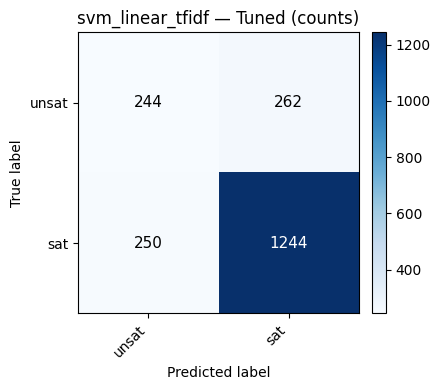

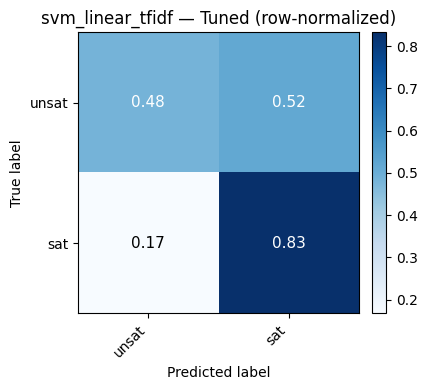


=== decision_tree_tfidf ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 10} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.3367    0.5850    0.4274       506
           1     0.8127    0.6098    0.6967      1494

    accuracy                         0.6035      2000
   macro avg     0.5747    0.5974    0.5621      2000
weighted avg     0.6923    0.6035    0.6286      2000



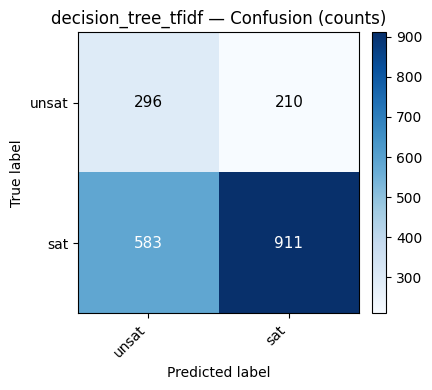

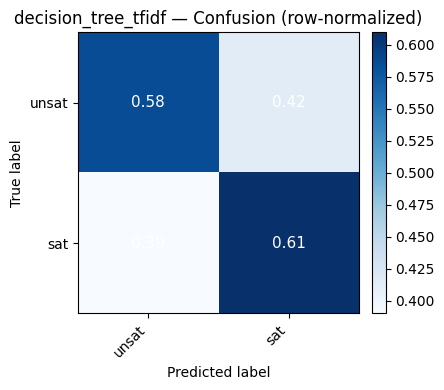


Validation report (threshold-tuned via proba, thr=0.3750, macro-F1=0.5770):
              precision    recall  f1-score   support

           0     0.3512    0.5435    0.4267       506
           1     0.8102    0.6600    0.7274      1494

    accuracy                         0.6305      2000
   macro avg     0.5807    0.6017    0.5770      2000
weighted avg     0.6941    0.6305    0.6513      2000



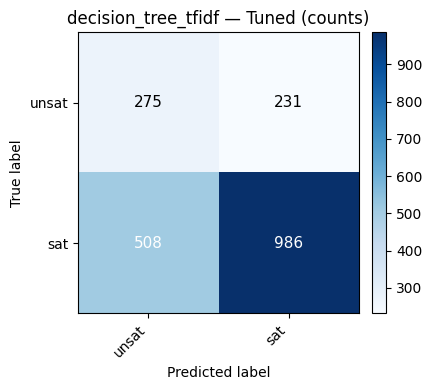

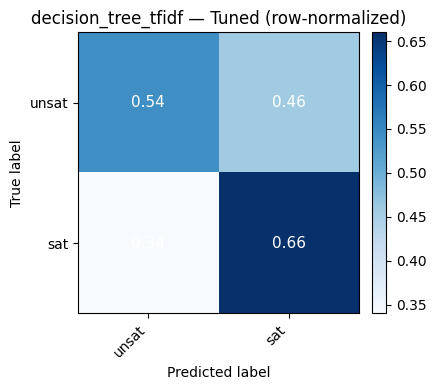


=== random_forest_tfidf ===
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__n_estimators': 100} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.5208    0.0988    0.1661       506
           1     0.7605    0.9692    0.8523      1494

    accuracy                         0.7490      2000
   macro avg     0.6407    0.5340    0.5092      2000
weighted avg     0.6999    0.7490    0.6787      2000



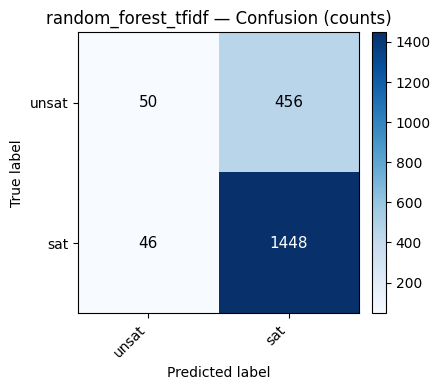

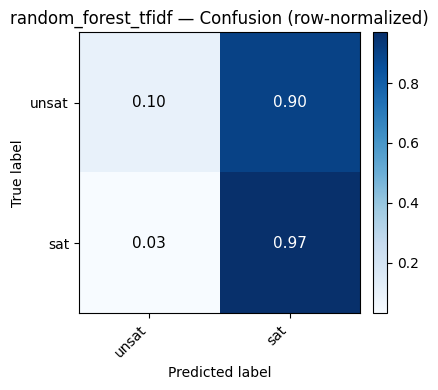


Validation report (threshold-tuned via proba, thr=0.6750, macro-F1=0.6041):
              precision    recall  f1-score   support

           0     0.3952    0.4585    0.4245       506
           1     0.8061    0.7624    0.7836      1494

    accuracy                         0.6855      2000
   macro avg     0.6007    0.6104    0.6041      2000
weighted avg     0.7021    0.6855    0.6928      2000



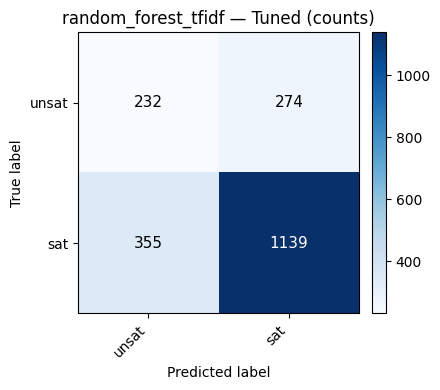

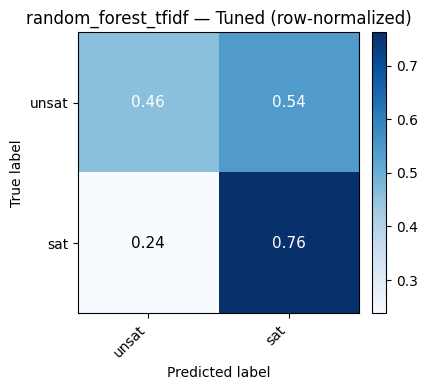

In [5]:
# ====== TRAIN TF-IDF MODELS (macro refit) + THRESHOLD TUNING ======
for name, (pipe, grid, n_jobs) in spaces.items():
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipe, grid, scoring=SCORING, refit=REFIT, cv=3, n_jobs=n_jobs, verbose=1, error_score="raise")
    gs.fit(Xtr_df, ytr)
    best = gs.best_estimator_
    print("Best params:", gs.best_params_, "| refit metric:", REFIT)

    # Default predictions
    yhat = best.predict(Xval_df)

    # Threshold tuning
    tuned_info = None
    if hasattr(best, "predict_proba"):
        p1 = best.predict_proba(Xval_df)[:, 1]
        thr, f1m = tune_threshold(p1, yval, use_proba=True)
        yhat_t = (p1 >= thr).astype(int)
        tuned_info = ("proba", thr, f1m, yhat_t)
    elif hasattr(best, "decision_function"):
        s = best.decision_function(Xval_df)
        thr, f1m = tune_threshold(s, yval, use_proba=False)
        yhat_t = (s >= thr).astype(int)
        tuned_info = ("decision", thr, f1m, yhat_t)

    # Reports + CMs (default)
    print("\nValidation report (default threshold):")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])
    cm_counts_path = SAVE_DIR / f"cm_{name}_counts.png"
    cm_norm_path   = SAVE_DIR / f"cm_{name}_normalized.png"
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    plot_cm(cm, CLASS_NAMES, f"{name} — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    # Reports + CMs (tuned)
    tuned_summary = None
    if tuned_info is not None:
        mode, thr, f1m, yhat_t = tuned_info
        print(f"\nValidation report (threshold-tuned via {mode}, thr={thr:.4f}, macro-F1={f1m:.4f}):")
        print(classification_report(yval, yhat_t, digits=4))
        cm_t = confusion_matrix(yval, yhat_t, labels=[0,1])
        cm_t_counts_path = SAVE_DIR / f"cm_{name}_tuned_counts.png"
        cm_t_norm_path   = SAVE_DIR / f"cm_{name}_tuned_normalized.png"
        plot_cm(cm_t, CLASS_NAMES, f"{name} — Tuned (counts)", normalize=False, save_path=cm_t_counts_path)
        plot_cm(cm_t, CLASS_NAMES, f"{name} — Tuned (row-normalized)", normalize=True, save_path=cm_t_norm_path)
        tuned_summary = {
            "mode": mode, "threshold": float(thr),
            "metrics_macro": metrics(yval, yhat_t, "macro"),
            "metrics_binary": metrics(yval, yhat_t, "binary"),
            "confusion_matrix": cm_t.tolist(),
            "cm_counts_path": str(cm_t_counts_path),
            "cm_normalized_path": str(cm_t_norm_path)
        }

    # Save model
    model_path = SAVE_DIR / f"{name}.joblib"
    joblib.dump(best, model_path)

    # Record summary
    summary["results"][name] = {
        "best_params": gs.best_params_,
        "refit_metric": REFIT,
        "metrics_macro_default": metrics(yval, yhat, "macro"),
        "metrics_binary_default": metrics(yval, yhat, "binary"),
        "confusion_matrix_default": cm.tolist(),
        "cm_counts_path_default": str(cm_counts_path),
        "cm_normalized_path_default": str(cm_norm_path),
        "tuned": tuned_summary,
        "model_path": str(model_path)
    }


=== logreg_emb_precomputed (with numeric/quant features) ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'C': 0.1} | refit metric: f1_macro

Validation report (default threshold):
              precision    recall  f1-score   support

           0     0.4219    0.6779    0.5201       506
           1     0.8627    0.6854    0.7639      1494

    accuracy                         0.6835      2000
   macro avg     0.6423    0.6816    0.6420      2000
weighted avg     0.7512    0.6835    0.7022      2000



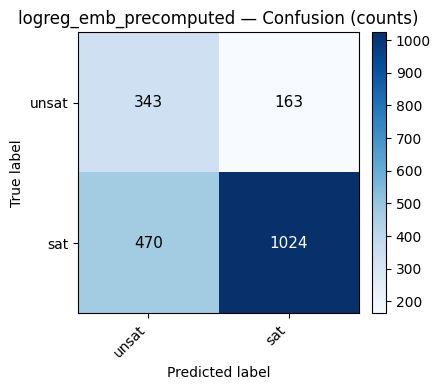

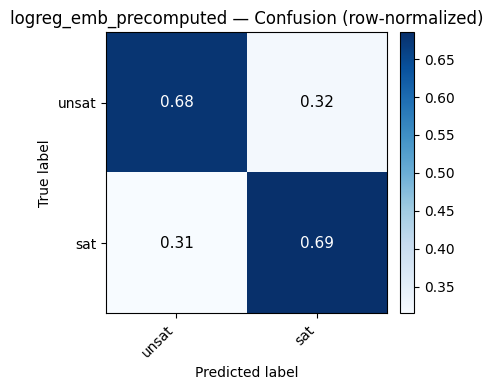


Validation report (threshold-tuned via proba, thr=0.3500, macro-F1=0.6585):
              precision    recall  f1-score   support

           0     0.5136    0.4486    0.4789       506
           1     0.8209    0.8561    0.8381      1494

    accuracy                         0.7530      2000
   macro avg     0.6672    0.6524    0.6585      2000
weighted avg     0.7432    0.7530    0.7473      2000



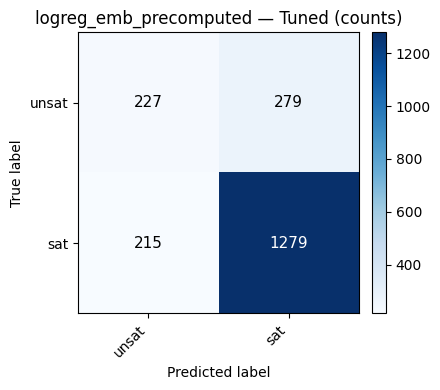

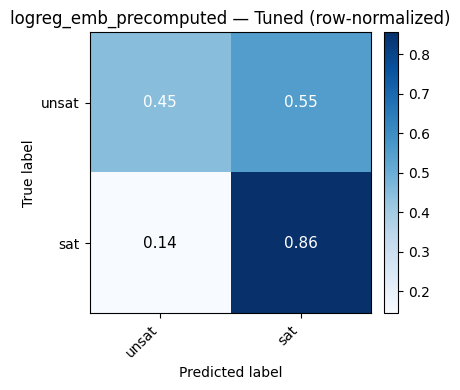

In [6]:
# ====== EMBEDDINGS VARIANT (precompute MiniLM + concat numeric) ======
if USE_EMBEDDINGS:
    try:
        from sentence_transformers import SentenceTransformer
    except Exception:
        print("Installing sentence-transformers ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"])
        from sentence_transformers import SentenceTransformer

    print("\n=== logreg_emb_precomputed (with numeric/quant features) ===")
    st_model = SentenceTransformer(EMB_MODEL_NAME)

    def embed(texts, batch_size=256):
        return st_model.encode(
            list(texts),
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=False
        )

    # Precompute embeddings
    Xtr_emb = embed(Xtr_df["text"])
    Xval_emb = embed(Xval_df["text"])

    # Numeric/quant arrays (dense)
    if numeric_cols:
        num_imputer = SimpleImputer(strategy="constant", fill_value=0.0)
        num_scaler  = StandardScaler(with_mean=True)
        Xtr_num = num_imputer.fit_transform(Xtr_df[numeric_cols].to_numpy(dtype=float))
        Xval_num = num_imputer.transform(Xval_df[numeric_cols].to_numpy(dtype=float))
        Xtr_num_s = num_scaler.fit_transform(Xtr_num)
        Xval_num_s = num_scaler.transform(Xval_num)
        Xtr_emb_aug = np.hstack([Xtr_emb, Xtr_num_s])
        Xval_emb_aug = np.hstack([Xval_emb, Xval_num_s])
        emb_bundle_extras = {"num_imputer": num_imputer, "num_scaler": num_scaler, "numeric_cols": numeric_cols}
    else:
        Xtr_emb_aug, Xval_emb_aug = Xtr_emb, Xval_emb
        emb_bundle_extras = {"numeric_cols": []}

    # Optional oversampling
    if USE_OVERSAMPLING:
        ros = RandomOverSampler(random_state=RANDOM_STATE)
        Xtr_emb_aug, ytr = ros.fit_resample(Xtr_emb_aug, ytr)
        print("Oversampled (emb) training shape:", Xtr_emb_aug.shape, "class balance:", np.bincount(ytr))

    # Grid search on class-balanced Logistic Regression (macro-F1 refit)
    logreg = LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=RANDOM_STATE,
        class_weight="balanced"
    )
    param_grid = {"C": [0.01, 0.1, 1.0, 10.0]}
    gs_emb = GridSearchCV(logreg, param_grid, scoring=SCORING, refit=REFIT, cv=3, n_jobs=-1, verbose=1, error_score="raise")
    gs_emb.fit(Xtr_emb_aug, ytr)
    print("Best params:", gs_emb.best_params_, "| refit metric:", REFIT)

    # Default predictions
    yhat = gs_emb.predict(Xval_emb_aug)

    # Threshold tuning (use proba)
    p1 = gs_emb.predict_proba(Xval_emb_aug)[:, 1]
    thr, f1m = tune_threshold(p1, yval, use_proba=True)
    yhat_t = (p1 >= thr).astype(int)

    # Reports + CMs
    print("\nValidation report (default threshold):")
    print(classification_report(yval, yhat, digits=4))
    cm = confusion_matrix(yval, yhat, labels=[0,1])
    cm_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_counts.png"
    cm_norm_path   = SAVE_DIR / f"cm_logreg_emb_precomputed_normalized.png"
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (counts)", normalize=False, save_path=cm_counts_path)
    plot_cm(cm, CLASS_NAMES, "logreg_emb_precomputed — Confusion (row-normalized)", normalize=True, save_path=cm_norm_path)

    print(f"\nValidation report (threshold-tuned via proba, thr={thr:.4f}, macro-F1={f1m:.4f}):")
    print(classification_report(yval, yhat_t, digits=4))
    cm_t = confusion_matrix(yval, yhat_t, labels=[0,1])
    cm_t_counts_path = SAVE_DIR / f"cm_logreg_emb_precomputed_tuned_counts.png"
    cm_t_norm_path   = SAVE_DIR / f"cm_logreg_emb_precomputed_tuned_normalized.png"
    plot_cm(cm_t, CLASS_NAMES, "logreg_emb_precomputed — Tuned (counts)", normalize=False, save_path=cm_t_counts_path)
    plot_cm(cm_t, CLASS_NAMES, "logreg_emb_precomputed — Tuned (row-normalized)", normalize=True, save_path=cm_t_norm_path)

    # Save bundle
    bundle = {"clf": gs_emb.best_estimator_, "embedding_model": EMB_MODEL_NAME}
    bundle.update(emb_bundle_extras)
    model_path = SAVE_DIR / "logreg_emb_precomputed.joblib"
    joblib.dump(bundle, model_path)

    summary["results"]["logreg_emb_precomputed"] = {
        "best_params": gs_emb.best_params_,
        "refit_metric": REFIT,
        "metrics_macro_default": metrics(yval, yhat, "macro"),
        "metrics_binary_default": metrics(yval, yhat, "binary"),
        "confusion_matrix_default": cm.tolist(),
        "cm_counts_path_default": str(cm_counts_path),
        "cm_normalized_path_default": str(cm_norm_path),
        "tuned": {
            "mode": "proba", "threshold": float(thr),
            "metrics_macro": metrics(yval, yhat_t, "macro"),
            "metrics_binary": metrics(yval, yhat_t, "binary"),
            "confusion_matrix": cm_t.tolist(),
            "cm_counts_path": str(cm_t_counts_path),
            "cm_normalized_path": str(cm_t_norm_path)
        },
        "model_path": str(model_path)
    }

In [7]:
# ====== SAVE SUMMARY + ZIP ======
rep_path = SAVE_DIR / "report.json"
with open(rep_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print(f"\nSaved models, CMs & report to: {SAVE_DIR.resolve()}")
print(json.dumps(summary, indent=2)[:1200], "...")

zip_path = shutil.make_archive("models_out", "zip", root_dir=SAVE_DIR)
print(f"\nZipped: {zip_path}")
try:
    files.download(zip_path)
except Exception:
    print("If the download prompt doesn't appear, use the Files pane to download 'models_out.zip'.")



Saved models, CMs & report to: /content/models_out
{
  "file": "relativetransitiveverb.csv",
  "numeric_cols": [
    "unary",
    "binary",
    "num_clauses",
    "prob",
    "q_all",
    "q_exists",
    "q_all_all",
    "q_all_exists",
    "q_exists_all",
    "q_exists_exists",
    "q_single_total",
    "q_pair_total"
  ],
  "results": {
    "logreg_tfidf": {
      "best_params": {
        "clf__C": 0.01
      },
      "refit_metric": "f1_macro",
      "metrics_macro_default": {
        "accuracy": 0.6875,
        "precision_macro": 0.6456359449061202,
        "recall_macro": 0.6856212729706705,
        "f1_macro": 0.6459700773909411
      },
      "metrics_binary_default": {
        "accuracy": 0.6875,
        "precision_binary": 0.8648194794290512,
        "recall_binary": 0.6894243641231593,
        "f1_binary": 0.7672253258845437
      },
      "confusion_matrix_default": [
        [
          345,
          161
        ],
        [
          464,
          1030
        ]
      ]